In [ ]:
!pip install pyspark


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=a26a767c7441d768a65e3d1e10ca770682dfb0965eaf1dbd9b0d65a2b1d6649c
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
import pandas as pd
# from surprise import Reader, SVD, Dataset, accuracy
# from surprise.model_selection import GridSearchCV, train_test_split, cross_validate
# pd.set_option('display.max_columns', None)

movies_df = pd.read_csv('sample_data/movies.csv')
ratings_df = pd.read_csv('sample_data/ratings.csv')

# New Section

In [ ]:
# Sparse user-item matrix.

user_item_matrix = ratings_df.pivot_table(index='userId', columns='movieId', values='rating')

print(user_item_matrix.head())

movieId  1       2       3       4       5       6       7       8       \
userId                                                                    
1           4.0     NaN     4.0     NaN     NaN     4.0     NaN     NaN   
2           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
3           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4           NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
5           4.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

movieId  9       10      ...  193565  193567  193571  193573  193579  193581  \
userId                   ...                                                   
1           NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
2           NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
3           NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     NaN   
4           NaN     NaN  ...     NaN     NaN     NaN     NaN     NaN     N

In [ ]:
# Counting the total number of non-NaNs and NaNs in the user-item matrix
non_nan_count = user_item_matrix.notna().sum().sum()
nan_count = user_item_matrix.isna().sum().sum()

print("Number of non-NaN values in the matrix:", non_nan_count)
print("Number of NaN values in the matrix:", nan_count)

Number of non-NaN values in the matrix: 100836
Number of NaN values in the matrix: 5830804


In [ ]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(user_item_matrix, test_size=0.3, random_state=42)  # 70% train, 30% temp
dev_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)  # 70% train, 30% temp



In [ ]:
import torch
import numpy as np
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from tqdm import tqdm_notebook as tqdm
import pandas as pd

class MatrixFactorization(torch.nn.Module):
    def __init__(self, n_users, n_items, n_factors=20):
        super().__init__()
        # create user embeddings
        self.user_factors = torch.nn.Embedding(n_users, n_factors)
        # create item embeddings
        self.item_factors = torch.nn.Embedding(n_items, n_factors)
        self.user_factors.weight.data.uniform_(0, 0.05)
        self.item_factors.weight.data.uniform_(0, 0.05)

    def forward(self, data):
        users, items = data[:,0], data[:,1]
        return (self.user_factors(users) * self.item_factors(items)).sum(1)

    def predict(self, user, item):
        return (self.user_factors(user) * self.item_factors(item)).sum(1)

class Loader(Dataset):
    def __init__(self, ratings_df):
        self.ratings = ratings_df.copy()
        users = ratings_df.userId.unique()
        movies = ratings_df.movieId.unique()

        self.userid2idx = {o:i for i,o in enumerate(users)}
        self.movieid2idx = {o:i for i,o in enumerate(movies)}

        self.idx2userid = {i:o for o,i in self.userid2idx.items()}
        self.idx2movieid = {i:o for o,i in self.movieid2idx.items()}

        self.ratings.movieId = ratings_df.movieId.apply(lambda x: self.movieid2idx[x])
        self.ratings.userId = ratings_df.userId.apply(lambda x: self.userid2idx[x])

        self.x = self.ratings.drop(['rating', 'timestamp'], axis=1).values
        self.y = self.ratings['rating'].values
        self.x, self.y = torch.tensor(self.x), torch.tensor(self.y)

    def __getitem__(self, index):
        return (self.x[index], self.y[index])

    def __len__(self):
        return len(self.ratings)

# Read your ratings data
ratings_df = pd.read_csv('sample_data/ratings.csv')

# Determine the number of unique users and items in your dataset
n_users = ratings_df['userId'].nunique()
n_items = ratings_df['movieId'].nunique()

# Create the model
model = MatrixFactorization(n_users, n_items, n_factors=8)

# Determine if GPU is available
cuda = torch.cuda.is_available()
if cuda:
    model = model.cuda()

# Define loss function and optimizer
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Create DataLoader
train_set = Loader(ratings_df)
train_loader = DataLoader(train_set, 128, shuffle=True)



Epoch [1/128], Loss: 11.0661, MAE: 3.1440
Epoch [2/128], Loss: 4.7490, MAE: 1.8650
Epoch [3/128], Loss: 2.4763, MAE: 1.2556
Epoch [4/128], Loss: 1.7222, MAE: 1.0174
Epoch [5/128], Loss: 1.3465, MAE: 0.8874
Epoch [6/128], Loss: 1.1286, MAE: 0.8084
Epoch [7/128], Loss: 0.9916, MAE: 0.7571
Epoch [8/128], Loss: 0.9003, MAE: 0.7223
Epoch [9/128], Loss: 0.8373, MAE: 0.6983
Epoch [10/128], Loss: 0.7924, MAE: 0.6807
Epoch [11/128], Loss: 0.7592, MAE: 0.6673
Epoch [12/128], Loss: 0.7351, MAE: 0.6568
Epoch [13/128], Loss: 0.7159, MAE: 0.6488
Epoch [14/128], Loss: 0.7015, MAE: 0.6421
Epoch [15/128], Loss: 0.6903, MAE: 0.6367
Epoch [16/128], Loss: 0.6818, MAE: 0.6321
Epoch [17/128], Loss: 0.6750, MAE: 0.6283
Epoch [18/128], Loss: 0.6699, MAE: 0.6243
Epoch [19/128], Loss: 0.6658, MAE: 0.6219
Epoch [20/128], Loss: 0.6627, MAE: 0.6196
Epoch [21/128], Loss: 0.6603, MAE: 0.6171
Epoch [22/128], Loss: 0.6586, MAE: 0.6161
Epoch [23/128], Loss: 0.6577, MAE: 0.6150
Epoch [24/128], Loss: 0.6564, MAE: 0.6143


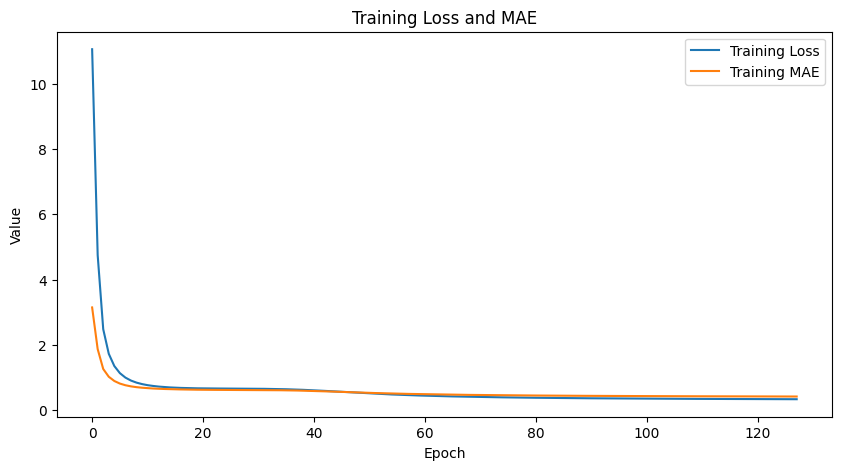

In [ ]:
# Train the model
num_epochs = 128
train_losses = []
train_mae = []
for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    total_mae = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        if cuda:
            data, target = data.cuda(), target.cuda()
        data, target = Variable(data), Variable(target)

        optimizer.zero_grad()
        output = model(data)
        loss = loss_fn(output, target.float())
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

        # Calculate MAE
        mae = torch.abs(output - target.float()).mean().item()
        total_mae += mae

    train_losses.append(total_loss / (batch_idx+1))
    train_mae.append(total_mae / (batch_idx+1))

    print('Epoch [{}/{}], Loss: {:.4f}, MAE: {:.4f}'.format(epoch+1, num_epochs, train_losses[-1], train_mae[-1]))

# Plot the training loss and MAE
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(train_mae, label='Training MAE')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.title('Training Loss and MAE')
plt.legend()
plt.show()


In [ ]:
user_embeddings = model.user_factors.weight.data.cpu().numpy()
item_embeddings = model.item_factors.weight.data.cpu().numpy()

# Now you can view these embeddings, for example, print the first few embeddings
print("User embeddings:")
print(user_embeddings[:5])
print("Item embeddings:")
print(item_embeddings[:5])

User embeddings:
[[ 0.7574567   0.8724308   1.9283137   1.2973926   1.5713644   1.0572586
   0.98077893  1.5110945 ]
 [ 0.75849223 -0.01778823  1.542164    1.8810481   0.83079636  0.8721721
   1.4830294   0.7535336 ]
 [ 0.57974607  0.6301595  -0.29348135  2.6224828  -2.4286828   0.82347804
   1.4532658   0.16097943]
 [ 3.2283359   1.2070463   0.5875966  -0.69195145  0.5127039  -1.666194
   2.438029    1.0996834 ]
 [ 1.6125228   1.3866918   0.68653256 -1.1789033   0.76397246  1.3418118
   0.5754259   2.4869938 ]]
Item embeddings:
[[ 0.5531707   0.3271541   0.554689    0.09828563  0.5646238   0.47589812
   0.90700173  0.33723155]
 [ 0.12506081  0.2705336   0.46337008  0.37270233  0.8889273  -0.0076066
   0.62554014  0.45749936]
 [ 0.61354554  0.61960346  0.3870648   0.5352818   0.1875619   0.30339748
   0.69754744  0.5205179 ]
 [ 0.31428817  0.5516905   0.9200098   0.5652401   0.40890792  0.26409778
   0.4542581   0.49415627]
 [ 0.7082133   0.87163734  0.70304006  0.38894928  0.20664355 

In [ ]:
!pip install implicit





     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 40.2 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col

# Create a Spark session
spark = SparkSession.builder.appName("MovieRecommendationALS").getOrCreate()

# Load data using Pandas
ratings_df = pd.read_csv('sample_data/ratings.csv')

# Randomly shuffle the data
ratings_df = ratings_df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split the data into train (70%), dev (15%), and test (15%)
train_df, temp_df = train_test_split(ratings_df, test_size=0.3, random_state=42)
dev_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

# Convert Pandas DataFrame to Spark DataFrame
def pandas_to_spark(pandas_df):
    return spark.createDataFrame(pandas_df)

train_spark_df = pandas_to_spark(train_df)
dev_spark_df = pandas_to_spark(dev_df)
test_spark_df = pandas_to_spark(test_df)

# Ensure column types are correct
train_spark_df = train_spark_df.withColumn("userId", col("userId").cast("integer"))
train_spark_df = train_spark_df.withColumn("movieId", col("movieId").cast("integer"))
train_spark_df = train_spark_df.withColumn("rating", col("rating").cast("float"))

dev_spark_df = dev_spark_df.withColumn("userId", col("userId").cast("integer"))
dev_spark_df = dev_spark_df.withColumn("movieId", col("movieId").cast("integer"))
dev_spark_df = dev_spark_df.withColumn("rating", col("rating").cast("float"))

test_spark_df = test_spark_df.withColumn("userId", col("userId").cast("integer"))
test_spark_df = test_spark_df.withColumn("movieId", col("movieId").cast("integer"))
test_spark_df = test_spark_df.withColumn("rating", col("rating").cast("float"))

# Check for overlapping user-item pairs
train_users = train_spark_df.select("userId").distinct()
train_items = train_spark_df.select("movieId").distinct()

dev_users = dev_spark_df.select("userId").distinct()
dev_items = dev_spark_df.select("movieId").distinct()

test_users = test_spark_df.select("userId").distinct()
test_items = test_spark_df.select("movieId").distinct()

common_dev_users = dev_users.intersect(train_users)
common_dev_items = dev_items.intersect(train_items)

common_test_users = test_users.intersect(train_users)
common_test_items = test_items.intersect(train_items)

print(f"Number of common users in train and dev: {common_dev_users.count()}")
print(f"Number of common items in train and dev: {common_dev_items.count()}")

print(f"Number of common users in train and test: {common_test_users.count()}")
print(f"Number of common items in train and test: {common_test_items.count()}")

# Initialize ALS model
als = ALS(
    maxIter=10,
    regParam=0.1,
    userCol="userId",
    itemCol="movieId",
    ratingCol="rating",
    coldStartStrategy="drop"
)

# Train the model
als_model = als.fit(train_spark_df)

# Evaluate the model using RMSE
evaluator_rmse = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

# Make predictions on the dev set
dev_predictions = als_model.transform(dev_spark_df)
dev_predictions = dev_predictions.na.drop()

if dev_predictions.count() > 0:
    rmse_dev = evaluator_rmse.evaluate(dev_predictions)
    print(f"Root-mean-square error on dev set = {rmse_dev}")
else:
    print("No predictions made on the dev set.")

# Make predictions on the test set
test_predictions = als_model.transform(test_spark_df)
test_predictions = test_predictions.na.drop()

if test_predictions.count() > 0:
    rmse_test = evaluator_rmse.evaluate(test_predictions)
    print(f"Root-mean-square error on test set = {rmse_test}")
else:
    print("No predictions made on the test set.")

# Evaluate the model using MAE
evaluator_mae = RegressionEvaluator(metricName="mae", labelCol="rating", predictionCol="prediction")

# Evaluate MAE on the dev set
if dev_predictions.count() > 0:
    mae_dev = evaluator_mae.evaluate(dev_predictions)
    print(f"Mean Absolute Error on dev set = {mae_dev}")
else:
    print("No predictions made on the dev set for MAE.")

# Evaluate MAE on the test set
if test_predictions.count() > 0:
    mae_test = evaluator_mae.evaluate(test_predictions)
    print(f"Mean Absolute Error on test set = {mae_test}")
else:
    print("No predictions made on the test set for MAE.")

# Stop the Spark session
spark.stop()


Number of common users in train and dev: 606
Number of common items in train and dev: 3835
Number of common users in train and test: 605
Number of common items in train and test: 3809
Root-mean-square error on dev set = 0.8960437703881748
Root-mean-square error on test set = 0.8857362343124777
Mean Absolute Error on dev set = 0.6894843576857149
Mean Absolute Error on test set = 0.6784973617268082


In [ ]:
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col

# Create a Spark session
spark = SparkSession.builder.appName("MovieRecommendationALS").getOrCreate()

# Load data using Spark
ratings_df = spark.read.csv('sample_data/ratings.csv', header=True, inferSchema=True)

# Split the data into train (70%), dev (15%), and test (15%)
train_df, temp_df = ratings_df.randomSplit([0.7, 0.3], seed=42)
dev_df, test_df = temp_df.randomSplit([0.5, 0.5], seed=42)

# Initialize ALS model
als = ALS(
    maxIter=10,
    regParam=0.1,
    userCol="userId",
    itemCol="movieId",
    ratingCol="rating",
    coldStartStrategy="drop"
)

# Train the model
als_model = als.fit(train_df)

# Evaluate the model using RMSE
evaluator_rmse = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")

# Make predictions on the dev set
dev_predictions = als_model.transform(dev_df)
dev_predictions = dev_predictions.na.drop()

if dev_predictions.count() > 0:
    rmse_dev = evaluator_rmse.evaluate(dev_predictions)
    print(f"Root-mean-square error on dev set = {rmse_dev}")
else:
    print("No predictions made on the dev set.")

# Make predictions on the test set
test_predictions = als_model.transform(test_df)
test_predictions = test_predictions.na.drop()

if test_predictions.count() > 0:
    rmse_test = evaluator_rmse.evaluate(test_predictions)
    print(f"Root-mean-square error on test set = {rmse_test}")
else:
    print("No predictions made on the test set.")

# Evaluate the model using MAE
evaluator_mae = RegressionEvaluator(metricName="mae", labelCol="rating", predictionCol="prediction")

# Evaluate MAE on the dev set
if dev_predictions.count() > 0:
    mae_dev = evaluator_mae.evaluate(dev_predictions)
    print(f"Mean Absolute Error on dev set = {mae_dev}")
else:
    print("No predictions made on the dev set for MAE.")

# Evaluate MAE on the test set
if test_predictions.count() > 0:
    mae_test = evaluator_mae.evaluate(test_predictions)
    print(f"Mean Absolute Error on test set = {mae_test}")
else:
    print("No predictions made on the test set for MAE.")

# Stop the Spark session
spark.stop()



Root-mean-square error on dev set = 0.8924067393273599
Root-mean-square error on test set = 0.8873387465020631
Mean Absolute Error on dev set = 0.6867010175649426
Mean Absolute Error on test set = 0.6811876774317979


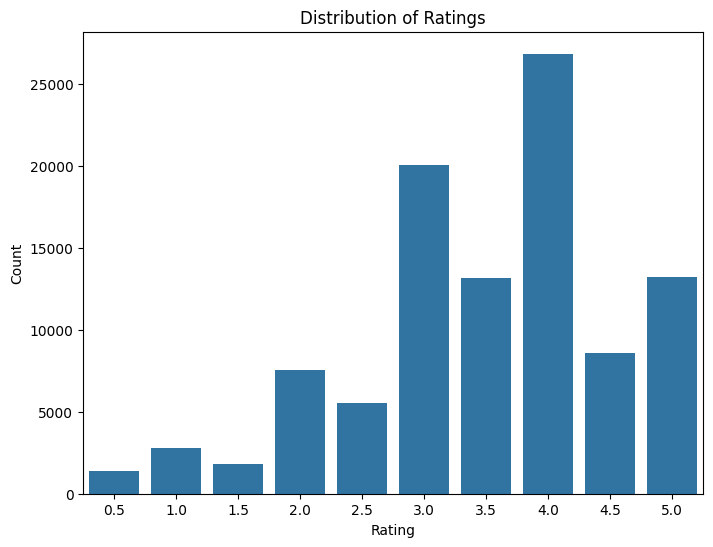

Root-mean-square error on dev set with maxIter=8: 0.8929094018554928
Mean Absolute Error on dev set with maxIter=8: 0.6863590003083719
Root-mean-square error on test set with maxIter=8: 0.8882759820648324
Mean Absolute Error on test set with maxIter=8: 0.6816124557336579


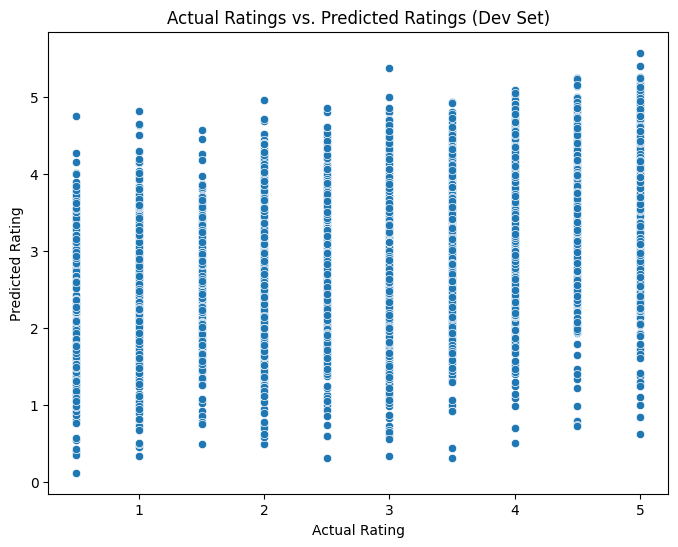

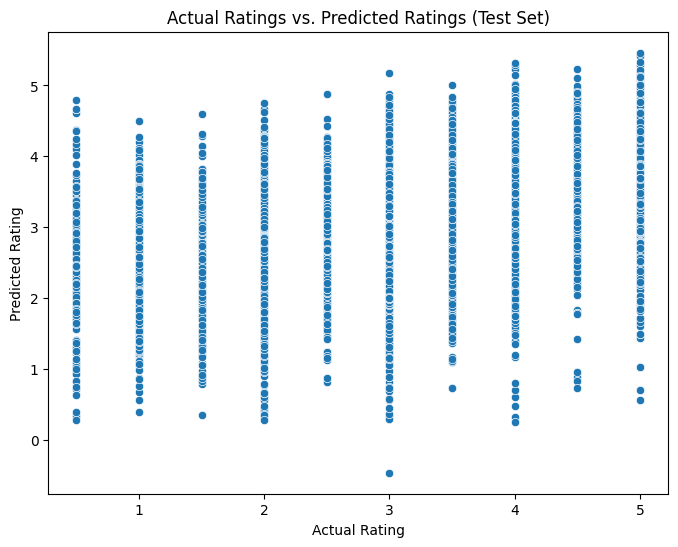

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql import SparkSession
from pyspark.ml.recommendation import ALS
from pyspark.ml.evaluation import RegressionEvaluator

# Create a Spark session
spark = SparkSession.builder.appName("MovieRecommendationALS").getOrCreate()

# Load data using Spark
ratings_df = spark.read.csv('sample_data/ratings.csv', header=True, inferSchema=True)

# Visualize the distribution of ratings
plt.figure(figsize=(8, 6))
sns.countplot(x='rating', data=ratings_df.toPandas())
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# Split the data into train (70%), dev (15%), and test (15%)
train_df, temp_df = ratings_df.randomSplit([0.7, 0.3], seed=42)
dev_df, test_df = temp_df.randomSplit([0.5, 0.5], seed=42)

# Initialize ALS model with maxIter = 8
als_8 = ALS(
    maxIter=8,
    regParam=0.1,
    userCol="userId",
    itemCol="movieId",
    ratingCol="rating",
    coldStartStrategy="drop"
)

# Train the model with maxIter = 8
als_model_8 = als_8.fit(train_df)

# Evaluate the model using RMSE and MAE
evaluator_rmse = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
evaluator_mae = RegressionEvaluator(metricName="mae", labelCol="rating", predictionCol="prediction")

# Make predictions on the dev set
dev_predictions_8 = als_model_8.transform(dev_df)
dev_predictions_8 = dev_predictions_8.na.drop()

# Evaluate RMSE on the dev set
rmse_dev_8 = evaluator_rmse.evaluate(dev_predictions_8)
print(f"Root-mean-square error on dev set with maxIter=8: {rmse_dev_8}")

# Evaluate MAE on the dev set
mae_dev_8 = evaluator_mae.evaluate(dev_predictions_8)
print(f"Mean Absolute Error on dev set with maxIter=8: {mae_dev_8}")

# Make predictions on the test set
test_predictions_8 = als_model_8.transform(test_df)
test_predictions_8 = test_predictions_8.na.drop()

# Evaluate RMSE on the test set
rmse_test_8 = evaluator_rmse.evaluate(test_predictions_8)
print(f"Root-mean-square error on test set with maxIter=8: {rmse_test_8}")

# Evaluate MAE on the test set
mae_test_8 = evaluator_mae.evaluate(test_predictions_8)
print(f"Mean Absolute Error on test set with maxIter=8: {mae_test_8}")

# Visualize actual ratings vs. predicted ratings on dev set
plt.figure(figsize=(8, 6))
sns.scatterplot(x='rating', y='prediction', data=dev_predictions_8.toPandas())
plt.title('Actual Ratings vs. Predicted Ratings (Dev Set)')
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.show()

# Visualize actual ratings vs. predicted ratings on test set
plt.figure(figsize=(8, 6))
sns.scatterplot(x='rating', y='prediction', data=test_predictions_8.toPandas())
plt.title('Actual Ratings vs. Predicted Ratings (Test Set)')
plt.xlabel('Actual Rating')
plt.ylabel('Predicted Rating')
plt.show()

# Stop the Spark session
spark.stop()


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F

# Create a Spark session
spark = SparkSession.builder.appName("ALSExample").getOrCreate()

# Convert pandas DataFrame to Spark DataFrame
def pandas_to_spark(df):
    return spark.createDataFrame(df.reset_index(drop=True))

# Convert pandas DataFrames to Spark DataFrames
train_spark = pandas_to_spark(train_df)
dev_spark = pandas_to_spark(dev_df)
test_spark = pandas_to_spark(test_df)

# Print schema to check for the correct column names
train_spark.printSchema()
dev_spark.printSchema()
test_spark.printSchema()

# Normalize ratings by subtracting the mean rating (3)
mean_rating = 3.0

def normalize_ratings(spark_df, mean_rating):
    if 'rating' in spark_df.columns:
        return spark_df.withColumn('rating', F.when(F.col('rating').isNotNull(), F.col('rating') - mean_rating).otherwise(0))


# Apply normalization
train_spark = normalize_ratings(train_spark, mean_rating)
dev_spark = normalize_ratings(dev_spark, mean_rating)
test_spark = normalize_ratings(test_spark, mean_rating)

# Ensure userId, movieId are integers and rating is float
train_spark = train_spark.select(
    F.col('userId').cast('int'),
    F.col('movieId').cast('int'),
    F.col('rating').cast('float'))

# Import ALS
from pyspark.ml.recommendation import ALS

# Initialize ALS
als = ALS(
    userCol='userId',
    itemCol='movieId',
    ratingCol='rating',
    nonnegative=True,  # Ensures non-negative factorization
    coldStartStrategy='drop'  # Drops any NaN predictions
)

# Fit the model on training data
model = als.fit(train_spark)

# Import tuning and evaluation modules
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import RegressionEvaluator

# Define evaluators for RMSE and MAE
rmse_evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating", predictionCol="prediction")
mae_evaluator = RegressionEvaluator(metricName="mae", labelCol="rating", predictionCol="prediction")

# Create parameter grid
param_grid = ParamGridBuilder() \
    .addGrid(als.rank, [10, 50, 100]) \
    .addGrid(als.maxIter, [5, 10, 20]) \
    .addGrid(als.regParam, [0.01, 0.05, 0.1]) \
    .build()

# Cross-validation
cross_val = CrossValidator(estimator=als, estimatorParamMaps=param_grid, evaluator=rmse_evaluator, numFolds=5)

# Fit cross-validation model on development data
cv_model = cross_val.fit(dev_spark)

# Get the best model from cross-validation
best_model = cv_model.bestModel

# Make predictions on the test data
predictions = best_model.transform(test_spark)

# Evaluate the model on test data using RMSE and MAE
rmse = rmse_evaluator.evaluate(predictions)
mae = mae_evaluator.evaluate(predictions)

print("Root-mean-square error (RMSE) = " + str(rmse))
print("Mean absolute error (MAE) = " + str(mae))


Streaming output truncated to the last 5000 lines.
 |-- 7056: double (nullable = true)
 |-- 7057: double (nullable = true)
 |-- 7058: double (nullable = true)
 |-- 7059: double (nullable = true)
 |-- 7060: double (nullable = true)
 |-- 7061: double (nullable = true)
 |-- 7062: double (nullable = true)
 |-- 7063: double (nullable = true)
 |-- 7064: double (nullable = true)
 |-- 7065: double (nullable = true)
 |-- 7067: double (nullable = true)
 |-- 7069: double (nullable = true)
 |-- 7070: double (nullable = true)
 |-- 7071: double (nullable = true)
 |-- 7072: double (nullable = true)
 |-- 7073: double (nullable = true)
 |-- 7074: double (nullable = true)
 |-- 7075: double (nullable = true)
 |-- 7076: double (nullable = true)
 |-- 7078: double (nullable = true)
 |-- 7079: double (nullable = true)
 |-- 7080: double (nullable = true)
 |-- 7082: double (nullable = true)
 |-- 7083: double (nullable = true)
 |-- 7084: double (nullable = true)
 |-- 7085: double (nullable = true)
 |-- 7086: do

AttributeError: 'NoneType' object has no attribute 'select'